# Test Antarctica

Compare AR5, Klimaatsignaal'21 and KNMI23 projections with observations

One issue with the way Antarctic contribution is added in Klimaatsignaal'21 is that the distribution is already skewed over the historical period so the mean growth too fast.

In [5]:
import importlib
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

sys.path.append('../code')
import func_misc as misc
import func_ant as ant

sys.path.append('../../../SLBudget/code/')
import SeaLevelContrib as slc

In [6]:
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

In [7]:
importlib.reload(slc)
importlib.reload(ant)

<module 'func_ant' from '/Users/dewilebars/Projects/Project_ProbSLR/SLProj/notebooks/../code/func_ant.py'>

In [8]:
SCE = 'ssp245'

N = int(1e5)
ys = 2006   # Starting point for the integration, if this is changed problems in functions
ye = 2100   # End year for computation

TIME2      = np.arange( ys, ye + 1, 1 )

GAM = 1
NormD  = np.random.normal(0, 1, N)

a1_up_a           = 0.061    # Unit is cm/y, equal to observations in 2006
a1_lo_a           = 0.021

In [9]:
def comp_plot_dist(X_ens, lo, hi, title_in, SCE):
    '''Easily compute the distribution, plot a histogram and table of percentile 
    values'''
    nbin = int(hi - lo)*20 
    X_pdf, bins = np.histogram(X_ens, bins=nbin, range=(lo, hi), density=True)
    bin_centers = (bins[1:] + bins[:-1])/2

    plt.bar(bin_centers, X_pdf, width=1)
    plt.ylabel('PDF')
    plt.title(title_in + ' for '+SCE)
    plt.show()
    
    Perc  = (1,5,10,17,20,50,80,83,90,95,99,99.5,99.9)
    perc = misc.perc_df(X_pdf, Perc, bin_centers)
    print("### Distribution ###")
    display(perc)

## Read some observational products for comparison

In [10]:
f20_glo_mean_df = slc.contrib_frederikse2020_glob("AIS", quant="mean")
f20_glo_mean_df = f20_glo_mean_df.rename(columns={"Antarctica":"Frederikse20_mean"})

f20_glo_upper_df = slc.contrib_frederikse2020_glob("AIS", quant="upper")
f20_glo_upper_df = f20_glo_upper_df.rename(columns={"Antarctica":"Frederikse20_upper"})

f20_glo_lower_df = slc.contrib_frederikse2020_glob("AIS", quant="lower")
f20_glo_lower_df = f20_glo_lower_df.rename(columns={"Antarctica":"Frederikse20_lower"})

f20_glo_df = f20_glo_mean_df.join([f20_glo_upper_df, f20_glo_lower_df])

f20_glo_df = f20_glo_df - f20_glo_df['Frederikse20_mean'].loc[2006]

In [11]:
f20_glo_df

,Frederikse20_mean,Frederikse20_upper,Frederikse20_lower
time,,,
1900,-0.708048,-0.088563,-1.373563
1901,-0.702595,-0.088563,-1.358563
1902,-0.697123,-0.088563,-1.348563
1903,-0.691746,-0.088563,-1.338563
1904,-0.686326,-0.088563,-1.323563
...,...,...,...
2014,0.418442,0.451437,0.381437
2015,0.511593,0.556437,0.461437
2016,0.492630,0.546437,0.431437


Difference between 2006 and 1995:

In [12]:
f20_glo_df.loc[2006] - f20_glo_df.loc[1995]

Frederikse20_mean     0.168652
Frederikse20_upper    0.040000
Frederikse20_lower    0.285000
dtype: float64

## Test the implementation AR6 numbers into klimaatsignaal'21

In [15]:
X_ant = ant.ant_ar6(TIME2, a1_up_a, a1_lo_a, SCE, NormD, 'KS21')

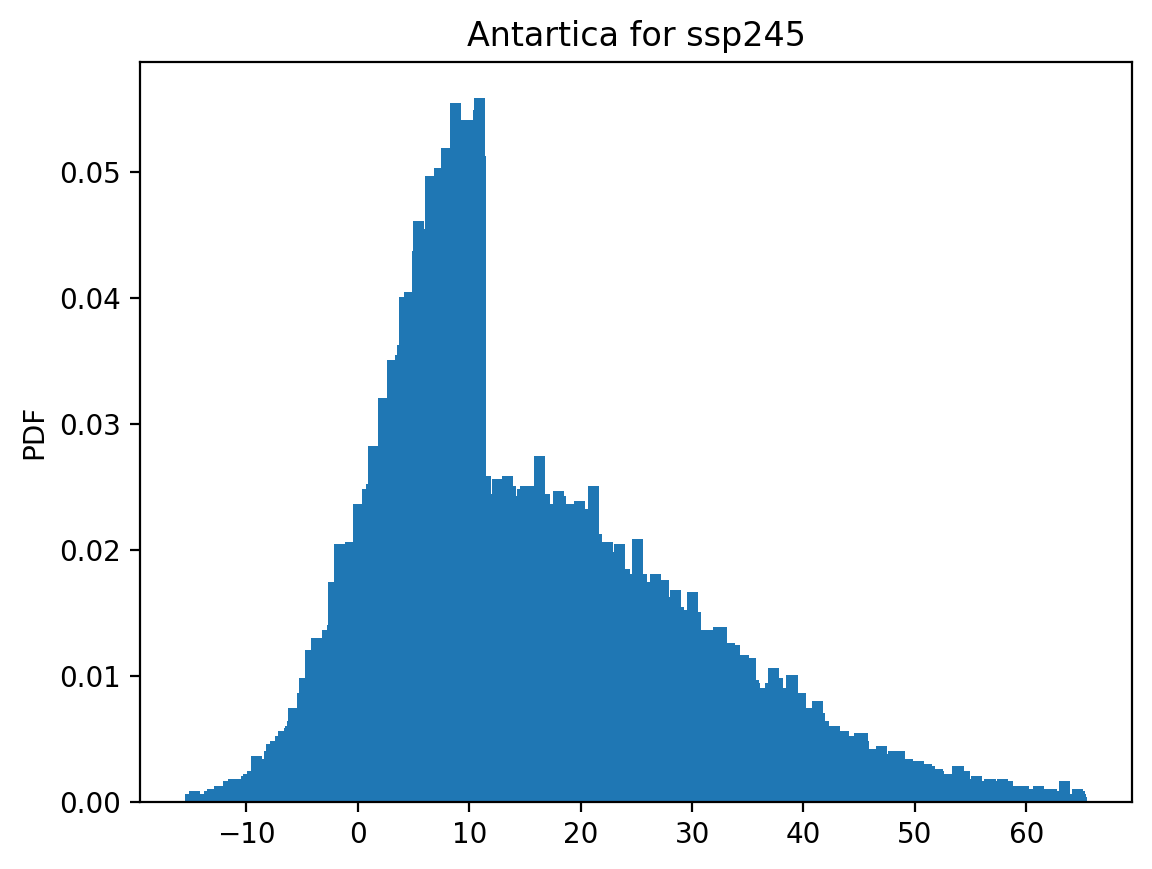

### Distribution ###


,values
percentiles,
1.0,-7.425
5.0,-2.075
10.0,0.725
17.0,3.375
20.0,4.275
50.0,10.975
80.0,25.975
83.0,27.975
90.0,33.875


In [16]:
comp_plot_dist(X_ant[:,-1], -15, 65, 'Antartica', 'ssp245')

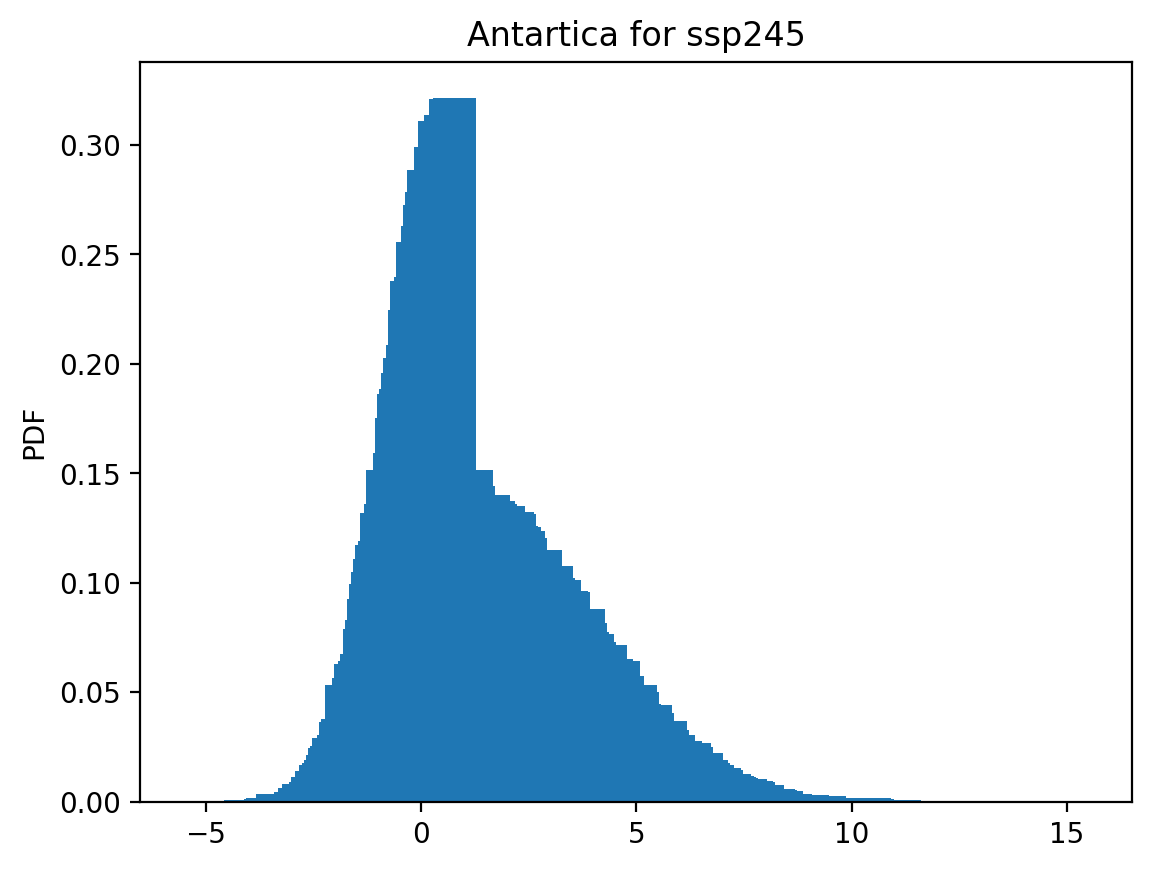

### Distribution ###


,values
percentiles,
1.0,-2.175
5.0,-1.325
10.0,-0.875
17.0,-0.425
20.0,-0.275
50.0,0.775
80.0,3.175
83.0,3.475
90.0,4.425


In [17]:
comp_plot_dist(X_ant[:,15], -5, 15, 'Antartica', 'ssp245')

The uncertainty of Antarctic contribution from the year 15 (2006+15 = 2021) is completely unrealistic.

In [18]:
def sample2df(TIME2, X):
    
    Perc  = np.array([1,5,10,17,20,50,80,83,90,95,99,99.5,99.9])
    
    df = pd.DataFrame(X)

    perc_df = df.quantile(Perc/100).transpose()
    perc_df.index = TIME2
    perc_df.index.name = "Time"
    
    return perc_df

In [19]:
KS21_df = sample2df(TIME2, X_ant)

## Read AR6 values

In [20]:
proj_dir = '/Users/dewilebars/Projects/Project_ProbSLR/Data_Proj/'
ar6_dir = f'{proj_dir}/Data_AR6/AR6_Projections/'
ar6_glo_med_dir = f'{ar6_dir}Global/medium_confidence/'

scen = 'ssp245'
file_path = f'{ar6_glo_med_dir}{scen}/AIS_{scen}_medium_confidence_values.nc'
ar6_ds = xr.open_dataset(file_path).sel(locations=-1)
ar6_ds = ar6_ds.rename({'years':'time'})

ar6_ds = ar6_ds/10 # Convert from mm to cm
ar6_ds['sea_level_change'].attrs['units'] = 'cm'

In [21]:
ar6_ds

<xarray.Dataset>
Dimensions:           (time: 14, quantiles: 107)
Coordinates:
  * time              (time) int32 2020 2030 2040 2050 ... 2120 2130 2140 2150
    locations         int32 -1
  * quantiles         (quantiles) float32 0.0 0.001 0.005 ... 0.995 0.999 1.0
Data variables:
    lat               float64 inf
    lon               float64 inf
    sea_level_change  (quantiles, time) float32 -0.3 -0.6 -1.2 ... 266.3 291.8
Attributes:
    description:  Combined confidence output file for AR6 sea-level change pr...
    history:      Created Mon Jul 12 15:16:11 2021
    source:       Files Combined: ../global/pboxes/pb_1f/ssp245/icesheets-pb1...

## Test new function for KNMI23

In [24]:
def ant_knmi23(TIME_loc, a1_up, a1_lo, sce, NormD):
    '''Total antarctic contribution as in AR6 table 9.9.
    Compute a discontinuous two sided half-normal distribution from the likely range.
    These numbers in 2100 are referenced to the period 1995-2014
    while the code uses 1986-2005 as a reference period but since there is only
    1 mm between these two periods this is neglected.'''
    
    if sce == 'ssp126':
        l_range = [3., 11., 27.] # 17pc, med, 83pc
    elif sce == 'ssp245':
        l_range = [3., 11., 29]
    elif sce == 'ssp585':
        l_range = [3., 12., 34.]
    elif sce == 'ssp585_hpp': # Low confidence in AR6
        l_range = [2., 19., 56.]
    else:
        print('Scenario not supported by ant_ar6')
    
    # Use the difference between the median and the 17 and 83pc to compute the
    # standard deviation
    std_lo_2100 = (l_range[1]-l_range[0])/0.95
    std_up_2100 = (l_range[2]-l_range[1])/0.95
    
    X_ant = proj2order_normal_assym(TIME_loc, a1_up, a1_lo, l_range[1], 
                                    std_lo_2100, std_up_2100, NormD)
    
    return X_ant

def proj2order_normal_assym(TIME_loc, a1_up, a1_lo, med_2100, 
                            std_lo_2100, std_up_2100, NormD):
    '''Project future values of sea level using present day uncertainty range of 
    the contribution in cm/year and uncertainty of total contribution in 2100 
    in cm. The uncertainty is represented by a two half-normal distributions,
    one above the median and the other one below.
    The median grows as a 2nd order polynomial and the standard deviations grow 
    linearly'''

    nb_y_loc = len(TIME_loc)
    N = len(NormD)
    
    speed_t0 = (a1_up+a1_lo)/2

    # Compute the highest order coefficient of the equations:
    a2_med  = (med_2100 - speed_t0 * (2100-TIME_loc[0]))/(2100 - TIME_loc[0])**2
    med = speed_t0 * (TIME_loc-TIME_loc[0]) + a2_med * (TIME_loc-TIME_loc[0])**2
    
    power_u_up = 2
    power_u_low = 2
    std_2006 = 0.06
    
    a_std_lo  = (std_lo_2100-std_2006)/(2100 - TIME_loc[0])**power_u_low
    std_lo = std_2006 + a_std_lo * (TIME_loc-TIME_loc[0])**power_u_low
    
    a_std_up  = (std_up_2100-std_2006)/(2100 - TIME_loc[0])**power_u_up
    std_up = std_2006 + a_std_up * (TIME_loc-TIME_loc[0])**power_u_up
    
    NormD_up = np.where(NormD>0, NormD, 0)
    NormD_lo = np.where(NormD<0, NormD, 0)
    
    X_out = (med[np.newaxis,:] + 
             std_lo[np.newaxis,:]*NormD_lo[:,np.newaxis] + 
             std_up[np.newaxis,:]*NormD_up[:,np.newaxis])

    return X_out

In [25]:
NormD  = np.random.normal(0, 1, N)

X_ant_knmi23 = ant_knmi23(TIME2, a1_up_a, a1_lo_a, SCE, NormD)

KNMI23_df = sample2df(TIME2, X_ant_knmi23)

In [45]:
X_ant_knmi23.shape

(100000, 95)

## Define projections based on van der Linden et al. 2023

### Explore the data

In [70]:
# Read input files
path_vdl = "/Users/dewilebars/Projects/Project_ProbSLR/Data_Proj/DataAntarctica_vdl/"

vdl_ds = xr.open_dataset(f"{path_vdl}slr_AMUNcalibrated_quadM_thetao_merged_biasadj_shelfbasedepth_historical+{SCE}_1850-2100.nc")

vdl_ds = vdl_ds.rename_vars({"__xarray_dataarray_variable__":"AA_dyn"})

vdl_da = vdl_ds.AA_dyn.sel(region = "SU")
vdl_da = vdl_da.stack(model_pairs=['model', 'ism'])
vdl_da = vdl_da.dropna(dim="model_pairs")

# How will we sample? Select individual time series directly
# Check Levermann method where this was also done


In [100]:
vdl_na = np.swapaxes(vdl_da.data, 0, 1)

modelsel = np.random.randint(0, len(vdl_da.model_pairs), N)

vdl_na_big = vdl_na[modelsel, :]

In [102]:
vdl_na_big.shape

(100000, 251)

In [98]:
max(modelsel)

195

Plot all the esm/ism pairs

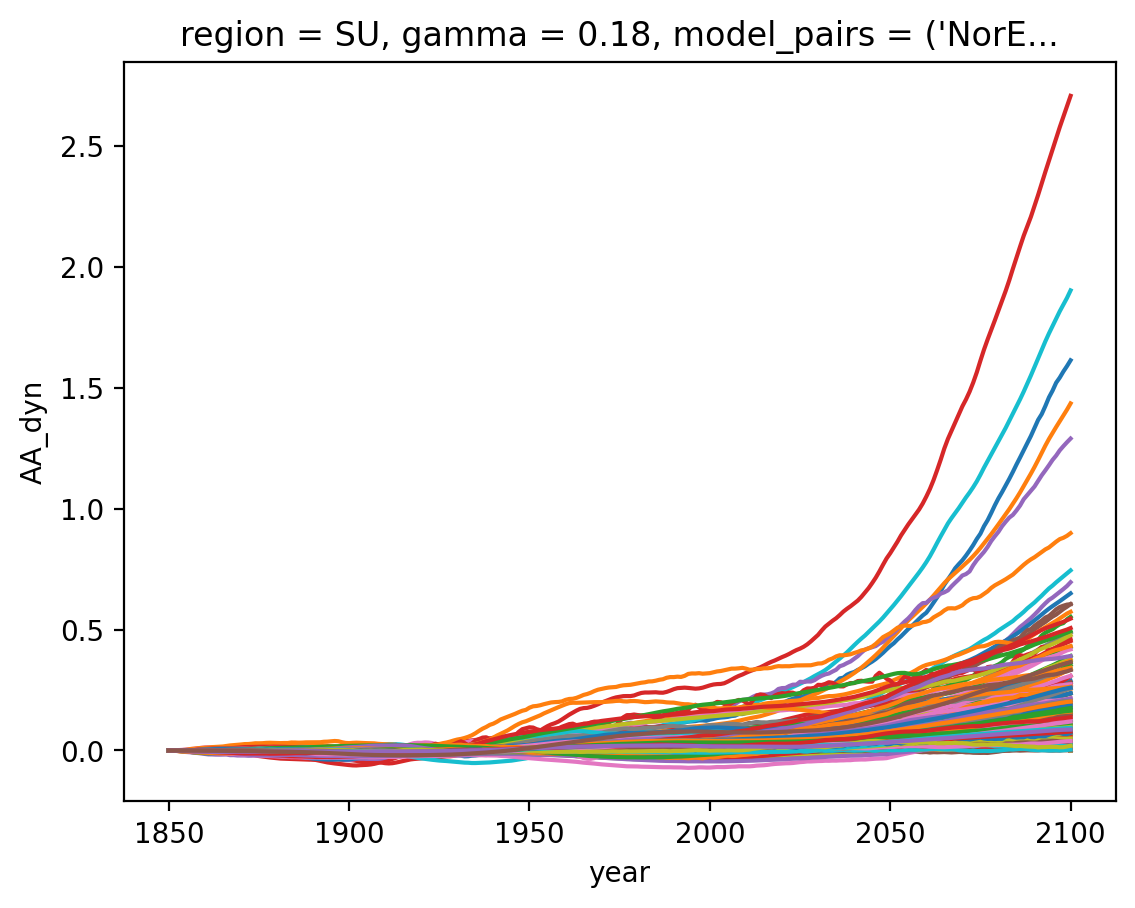

In [72]:
for i in range(len(vdl_da.model_pairs)):
    vdl_da.isel(model_pairs=i).plot()

In [83]:
# For this pair of values Antarctica contributes over 2.5m to sea level rise
vdl_da.sel(year=2100).argmax()

<xarray.DataArray 'AA_dyn' ()>
array(33)
Coordinates:
    region   <U2 'SU'
    year     int64 2100

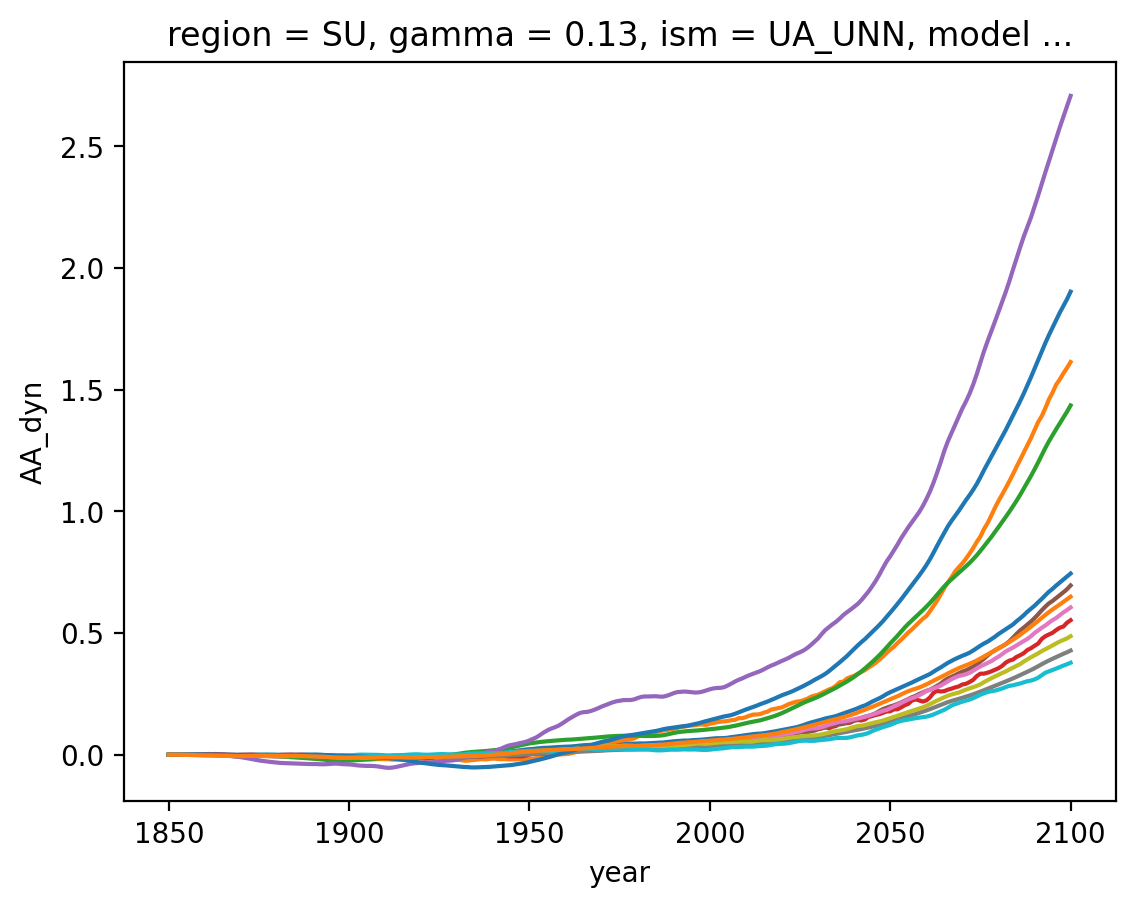

In [84]:
vdl_da_cas = vdl_da.sel(model='CAS-ESM2-0')

for i in range(len(vdl_da_cas.ism)):
    vdl_da_cas.isel(ism=i).plot()

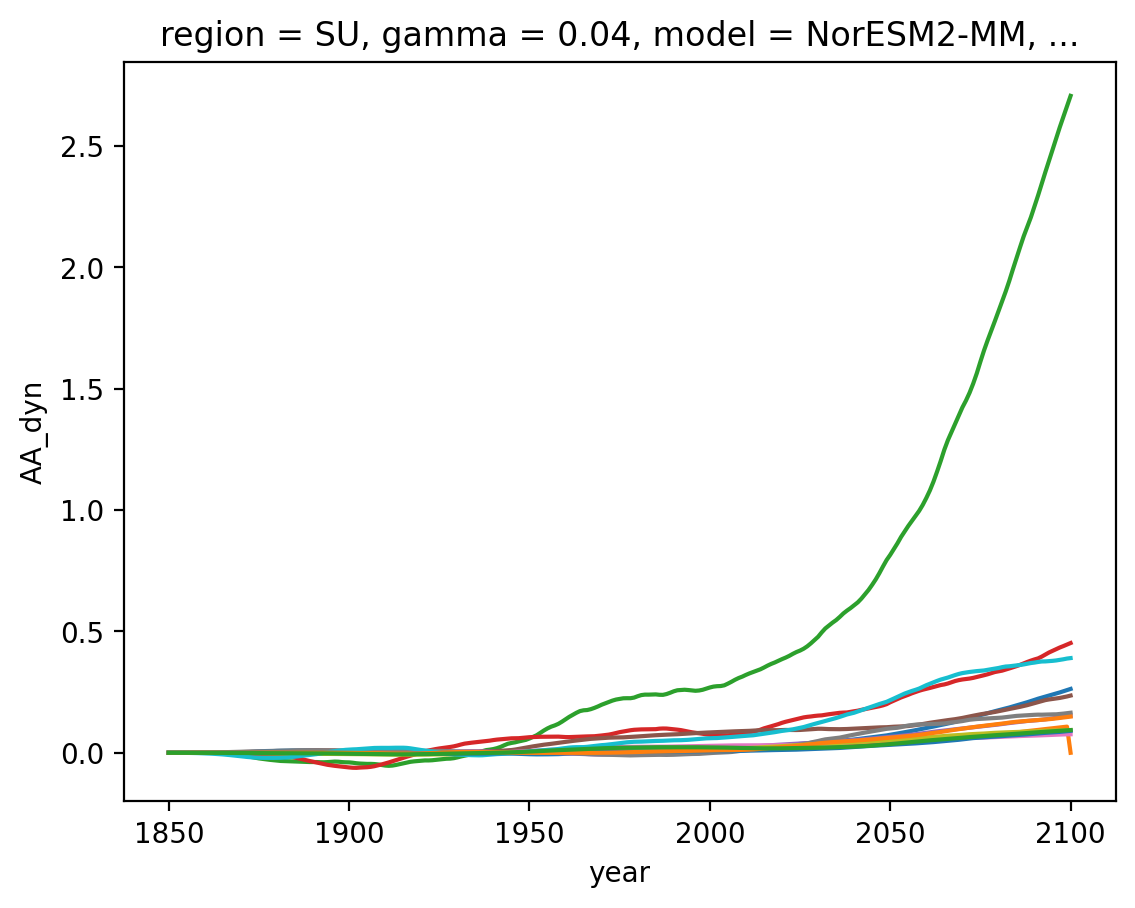

In [85]:
vdl_da_imau = vdl_da.sel(ism='IMAU_VUB')

for i in range(len(vdl_da_imau.model)):
    vdl_da_imau.isel(model=i).plot()

In [176]:
for ism in vdl_da.ism:
    vdl_da.loc[2100,'CAMS-CSM1-0'].loc[ism] = vdl_da.loc[2099,'CAMS-CSM1-0'].loc[ism]

KeyError: "not all values found in index 'ism'. Try setting the `method` keyword argument (example: method='nearest')."

In [183]:
vdl_da.sel(model='CAMS-CSM1-0').ism

<xarray.DataArray 'ism' (ism: 15)>
array(['AISM_VUB', 'BISI_LBL_1KM', 'CISM_NCA', 'FETI_VUB', 'IMAU_VUB',
       'ISSM_JPL', 'ISSM_UCI', 'MALI_LAN', 'PISM_AWI', 'PISM_DMI', 'PISM_PIK',
       'PISM_VUW', 'PS3D_PSU', 'SICO_UHO', 'UA_UNN'], dtype=object)
Coordinates:
    region   <U2 'SU'
    gamma    (ism) float64 0.42 0.2 0.69 0.31 0.11 ... 0.42 0.1 0.47 0.27 0.1
  * ism      (ism) object 'AISM_VUB' 'BISI_LBL_1KM' ... 'SICO_UHO' 'UA_UNN'
    model    <U11 'CAMS-CSM1-0'

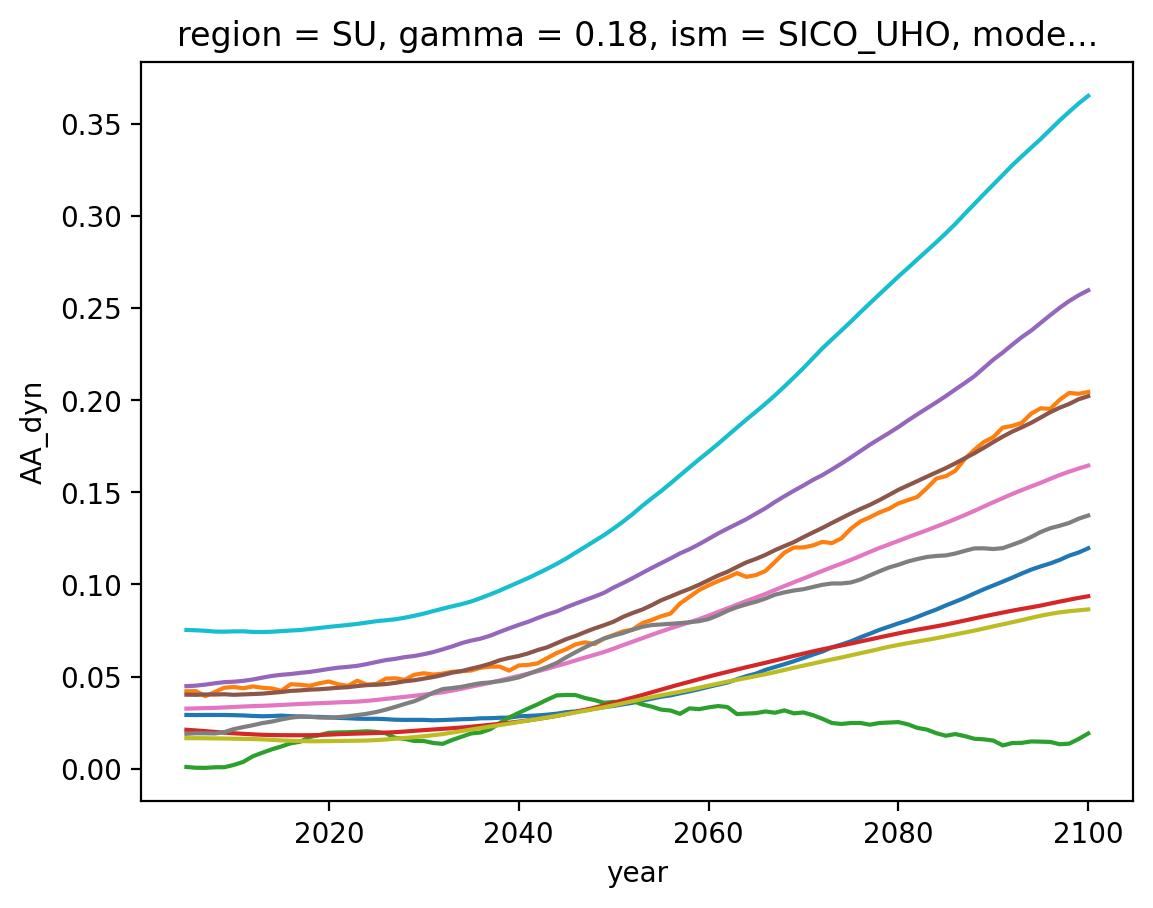

In [149]:
vdl_da_cas = vdl_da.sel(model='NorESM2-MM') # 'CAMS-CSM1-0' problem

for i in range(len(vdl_da_cas.ism)):
    vdl_da_cas.isel(ism=i).plot()

In [136]:
vdl_da_imau

<xarray.DataArray 'AA_dyn' (year: 251, model: 13)>
array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.76065997e-06, -2.26166198e-06,  5.46172281e-05, ...,
         1.17459355e-05,  9.66174097e-07,  7.40799376e-07],
       [ 2.59201208e-06, -8.96725803e-06,  1.21236271e-04, ...,
         3.14584460e-05, -3.43833335e-06,  5.90190592e-07],
       ...,
       [ 2.53388533e-01,  1.05893188e-01,  2.62036397e+00, ...,
         8.74116231e-02,  1.45038186e-01,  9.16881210e-02],
       [ 2.58196021e-01,  1.07715211e-01,  2.66297752e+00, ...,
         8.88089157e-02,  1.47061734e-01,  9.26760405e-02],
       [ 2.63085242e-01,  0.00000000e+00,  2.70648714e+00, ...,
         9.03506855e-02,  1.49093243e-01,  9.35754479e-02]])
Coordinates:
    region   <U2 'SU'
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2096 2097 2098 2099 2100
    gamma    (model) float64 0.2 0.11 0.87 0.62 0.08 ... 0.31 0.09 0.21 0.04
  * model    (model) object 'ACCESS-CM2' 'CAMS-CSM1-0' ... 'NorESM2-MM'
    ism      <U8 'IMAU_VUB'

### Prepare function

In [215]:
def ant_dyn_vdl23(scen, N):
    # Use projections from van der Linden et al. 2023
    
    path_vdl = "/Users/dewilebars/Projects/Project_ProbSLR/Data_Proj/DataAntarctica_vdl/"

    vdl_ds = xr.open_dataset(f"{path_vdl}slr_AMUNcalibrated_quadM_thetao_merged_biasadj_shelfbasedepth_historical+{scen}_1850-2100.nc")

    vdl_ds = vdl_ds.rename_vars({"__xarray_dataarray_variable__":"AA_dyn"})

    vdl_da = vdl_ds.AA_dyn.sel(region = "SU")
    
    # For one model values in 2100 are 0
    vdl_da.loc[:,'CAMS-CSM1-0', 2100] = vdl_da.loc[:,'CAMS-CSM1-0', 2099]
    
    vdl_da = vdl_da.stack(model_pairs=['model', 'ism'])
    vdl_da = vdl_da.dropna(dim="model_pairs")
    
    # Take the correct reference period
    vdl_da = vdl_da - vdl_da.sel(year=slice(1995,2014)).mean(dim="year") # Change reference period!!!!!! 1986-2005
    
    vdl_da = vdl_da.sel(year=slice(2006,2100))
    
    vdl_na = np.swapaxes(vdl_da.data, 0, 1)
    
    modelsel = np.random.randint(0, len(vdl_da.model_pairs), N)

    vdl_na_big = vdl_na[modelsel, :]
    
    return vdl_na_big

In [216]:
ROOT = '/Users/dewilebars/Projects/Project_ProbSLR/Data_Proj/'
start_date = 1980    # Start reading data
NormD  = np.random.normal(0, 1, N)

TGLOB = misc.make_tglob_array(ROOT, 'AR6', SCE, start_date, ye , 3)
TGLOBs = TGLOB.sel(time=slice(ys,None))
T_a = TGLOBs - TGLOB.sel(time=slice(1995,2014)).mean(dim='time') # Antarctic SMB
Td_a = misc.normal_distrib(T_a, 1, NormD)

Aoc = 3.6704e14              # Ocean Area (m2)
rho_w = 1e3                  # Water density (kg.m-3)
fac = -1e12 / (Aoc * rho_w)  # Convert Giga tones to m sea level

SMB = ant.ant_smb_ar5(NormD, fac, Td_a)

In [217]:
scen = "ssp245"

vdl_na_ssp245 = ant_dyn_vdl23(SCE, N)*100 + SMB

vdl23_df = sample2df(TIME2, vdl_na_ssp245)

Here we combine with SMB from the same formula as AR5.

In [218]:
vdl23_df

,0.010,0.050,0.100,0.170,0.200,0.500,0.800,0.830,0.900,0.950,0.990,0.995,0.999
Time,,,,,,,,,,,,,
2006,-0.377717,-0.218042,-0.108647,-0.052712,-0.042275,0.038643,0.120298,0.134719,0.178816,0.279377,0.570892,0.884074,0.885504
2007,-0.344528,-0.182727,-0.099458,-0.020468,-0.015695,0.088312,0.216624,0.235116,0.308414,0.442691,0.941594,0.987425,0.990477
2008,-0.224672,-0.111037,-0.041721,0.021697,0.032539,0.162623,0.319839,0.359995,0.442088,0.779273,1.715239,1.723492,1.870771
2009,-0.193046,-0.101456,-0.020744,0.075532,0.086468,0.231765,0.427670,0.457475,0.594662,1.004651,2.294769,2.308270,2.541765
2010,-0.195130,-0.052989,0.010628,0.094789,0.110361,0.283566,0.506252,0.539344,0.716305,0.983688,2.714170,3.003471,3.017738
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2096,-2.953632,-0.219807,1.668941,3.407525,4.041365,9.877321,25.067332,28.372987,38.478653,57.623396,179.784953,252.289696,256.232983
2097,-3.032945,-0.233510,1.684652,3.451926,4.109396,10.083618,25.642717,29.162599,39.211685,58.669235,183.902834,258.601133,262.621109
2098,-3.088656,-0.283390,1.667830,3.473130,4.159393,10.251318,26.240475,29.808677,39.936020,60.170760,187.904403,265.121270,269.218150


## Look into time series

(-0.5, 4.0)

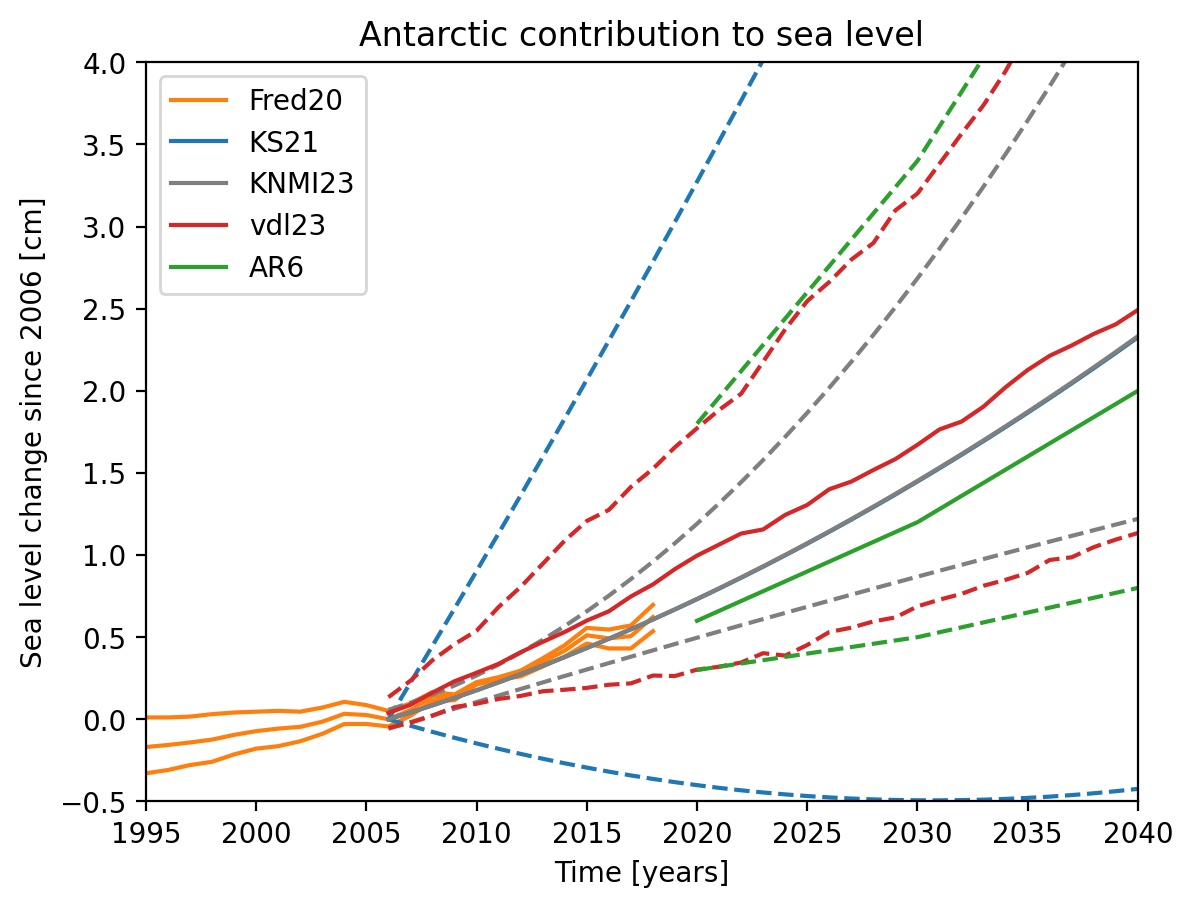

In [219]:
%%capture --no-display 
# Avoids printing useless warnings

fig, ax = plt.subplots()

f20_glo_df.plot(ax=ax, color='tab:orange')

KS21_df[.50].plot(ax=ax, color='tab:blue')
KS21_df[[.17, .83]].plot(ax=ax, color='tab:blue', linestyle='--')

KNMI23_df[.50].plot(ax=ax, color='tab:grey')
KNMI23_df[[.17, .83]].plot(ax=ax, color='tab:grey', linestyle='--')

vdl23_df[.50].plot(ax=ax, color='tab:red')
vdl23_df[[.17, .83]].plot(ax=ax, color='tab:red', linestyle='--')

ar6_ds.sea_level_change.sel(quantiles=0.5).plot(color='tab:green')
ar6_ds.sea_level_change.sel(quantiles=0.17).plot(color='tab:green', linestyle='--')
ar6_ds.sea_level_change.sel(quantiles=0.83).plot(color='tab:green', linestyle='--')

ax.legend(['_nolegend_', 'Fred20', '_nolegend_', 
           'KS21', '_nolegend_', '_nolegend_', 
           'KNMI23', '_nolegend_', '_nolegend_',
           'vdl23', '_nolegend_', '_nolegend_',
           'AR6', '_nolegend_', '_nolegend_'])

ax.set_title('Antarctic contribution to sea level')
ax.set_xlabel('Time [years]')
ax.set_ylabel('Sea level change since 2006 [cm]')

ax.set_xlim([1995, 2040])
ax.set_ylim([-0.5, 4])



(-5.0, 35.0)

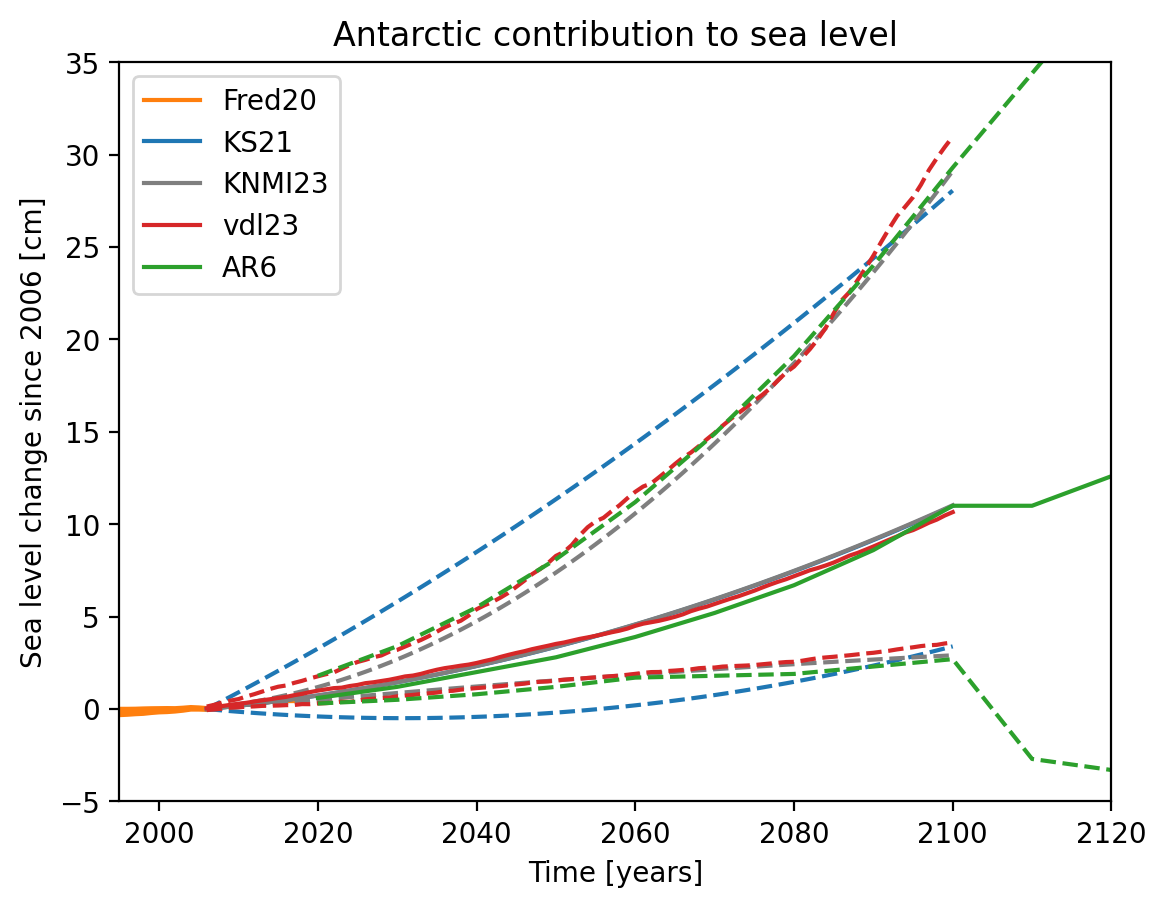

In [220]:
%%capture --no-display 
# Avoids printing useless warnings

fig, ax = plt.subplots()

f20_glo_df.plot(ax=ax, color='tab:orange')

KS21_df[.50].plot(ax=ax, color='tab:blue')
KS21_df[[.17, .83]].plot(ax=ax, color='tab:blue', linestyle='--')

KNMI23_df[.50].plot(ax=ax, color='tab:grey')
KNMI23_df[[.17, .83]].plot(ax=ax, color='tab:grey', linestyle='--')

vdl23_df[.50].plot(ax=ax, color='tab:red')
vdl23_df[[.17, .83]].plot(ax=ax, color='tab:red', linestyle='--')

ar6_ds.sea_level_change.sel(quantiles=0.5).plot(color='tab:green')
ar6_ds.sea_level_change.sel(quantiles=0.17).plot(color='tab:green', linestyle='--')
ar6_ds.sea_level_change.sel(quantiles=0.83).plot(color='tab:green', linestyle='--')

ax.legend(['_nolegend_', 'Fred20', '_nolegend_', 
           'KS21', '_nolegend_', '_nolegend_', 
           'KNMI23', '_nolegend_', '_nolegend_',
           'vdl23', '_nolegend_', '_nolegend_',
           'AR6', '_nolegend_', '_nolegend_'])

ax.set_title('Antarctic contribution to sea level')
ax.set_xlabel('Time [years]')
ax.set_ylabel('Sea level change since 2006 [cm]')

ax.set_xlim([1995, 2120])
ax.set_ylim([-5, 35])

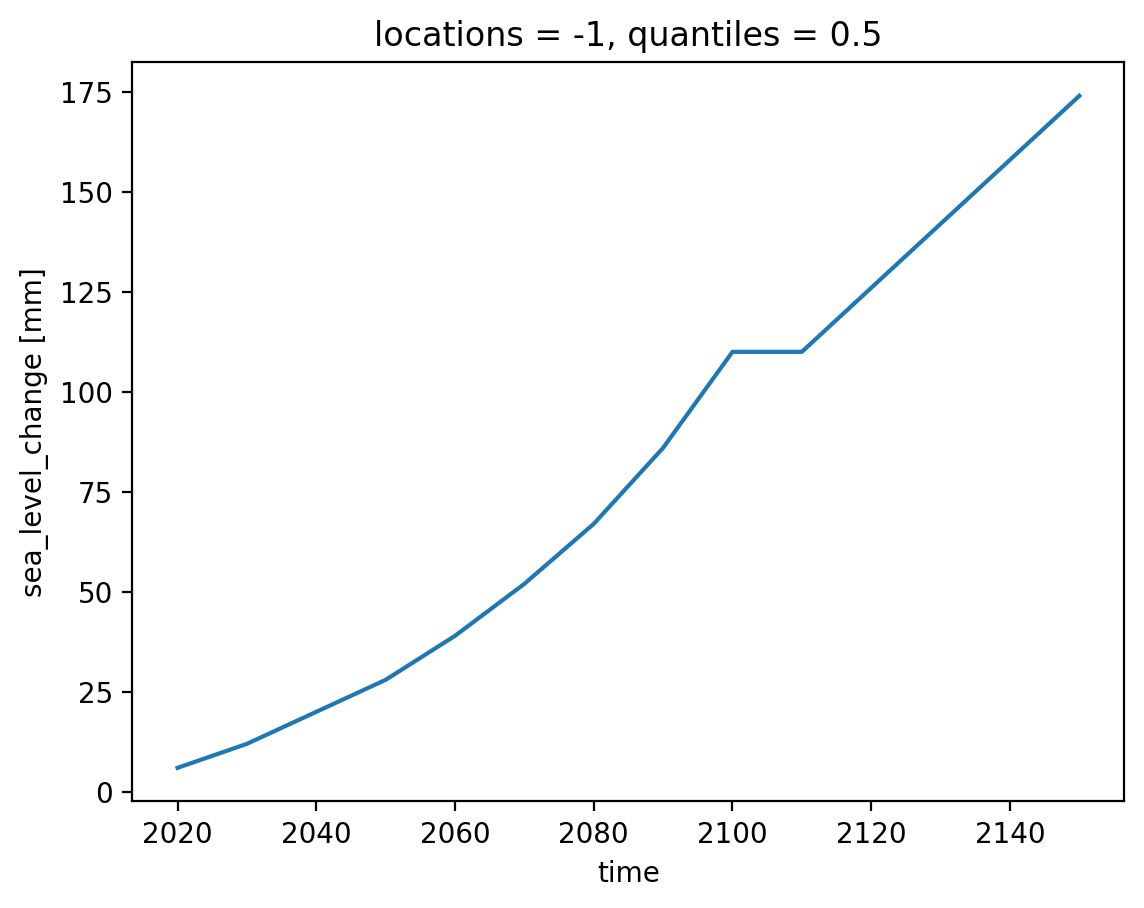

In [82]:
ar6_ds.sea_level_change.sel(quantiles=0.50).plot()